In [32]:
import json, nltk
from collections import Counter
from pathlib import Path
from typing import TypedDict

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from nltk.corpus import stopwords

class CutData(TypedDict):
    '''type of the cuts json data file'''
    label: str
    start: float
    end: float
    video: str
    playlist: str

plt.style.use("ggplot")
plt.rcParams.update({'font.size': 18})
color="dodgerblue"
figs_path = Path("../data/graphs/samples")
figs_path.mkdir(exist_ok=True)

def save_fig(fig, name: str, path: Path):
    fig.get_figure().savefig(path.resolve() / name, bbox_inches = 'tight')

def clean_word(word: str, chars: list[str], rep: str = '') -> str:
    for c in chars:
        word = word.replace(c,rep)
    return word

inv_chars = ['\n', ',', '.', '"', '-', '?', '!', '¿', '¡', '_']

# cuts data contains list of data for each cut json file
cuts_data: list[CutData] = []
# words contain list of words for each cut, excepting stopwords
words: dict[str, list[str]] = {}
# times contain lenght (s) for each cut
times: dict[str, float] = {}
# videos contains videos names
videos: set[str] = set()

# If not downloaded, run
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

path = Path("../data/cuts/")
cuts = map(lambda p: Path(str(p.resolve())[:-3] + "json"), path.glob('**/*.mp4'))

for idx, cut in enumerate(cuts):
    with cut.open() as datafile:
        data: CutData = json.load(datafile)
    cuts_data.append(data)
    words[str(cut)] = [w for w in clean_word(data['label'], inv_chars, ' ').lower().split(' ') if (w and w not in stop_words)]
    times[str(cut)] = (data['end'] - data['start'])
    videos.add(data['video'])

print(f'''La base de datos contiene:
    {len(videos)} videos completos
    {len(cuts_data)} clips resultantes de dividir los videos de acuerdo a los subtítulos
    {(sum(times.values())/60)/60} hs de video''')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pdalbianco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La base de datos contiene:
    64 videos completos
    14880 clips resultantes de dividir los videos de acuerdo a los subtítulos
    21.78172527777782 hs de video


Videos por playlist

count        4.000000
mean      3720.000000
std       6659.176125
min         44.000000
25%         99.500000
50%        575.000000
75%       4195.500000
max      13686.000000
dtype: float64

<AxesSubplot:>

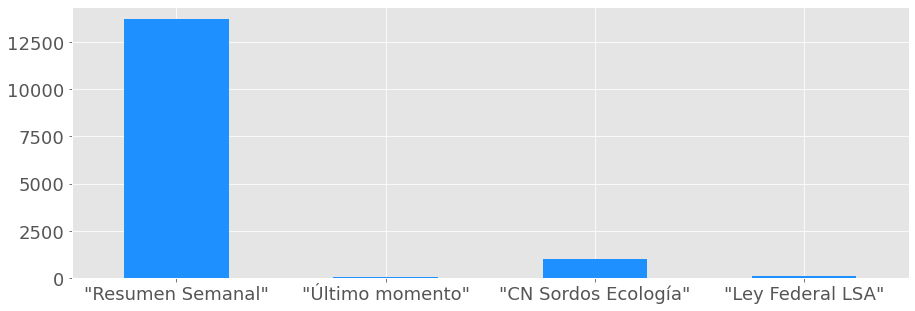

In [23]:
playlists_names = {
    'resumen_semanal': '"Resumen Semanal"',
    'ultimo_momento': '"Último momento"',
    'ecologia': '"CN Sordos Ecología"',
    'ley_federal_lsa': '"Ley Federal LSA"'
}

playlist_s: pd.Series = pd.Series(Counter(map(lambda cd: playlists_names[cd['playlist']], cuts_data)))
display(playlist_s.describe())
playlists_fig = playlist_s.plot.bar(figsize=(15,5), color=color)
plt.xticks(rotation=0)
display(playlists_fig)
save_fig(playlists_fig, "videos_by_playlists.png", figs_path)

Estadísticas de la duración de los clips:

count    14880.000000
mean         5.269772
std          2.732944
min          0.450000
25%          3.330000
50%          4.670000
75%          6.540000
max         25.580000
dtype: float64

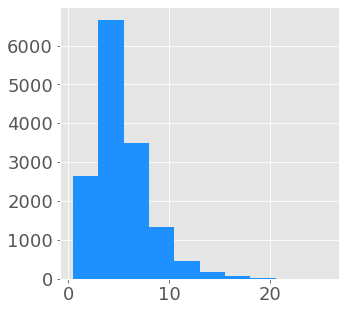

In [24]:
clip_times_s = pd.Series(times)
display(clip_times_s.describe())
clip_times_hist_fig = clip_times_s.plot.hist(figsize=(5,5), color="dodgerblue")
clip_times_hist_fig.set_ylabel("")
save_fig(clip_times_hist_fig, "clip_times_hist.png", figs_path)

Estadísticas de cantidad de palabras por clip:

count    14880.000000
mean         4.784812
std          1.817335
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         14.000000
dtype: float64

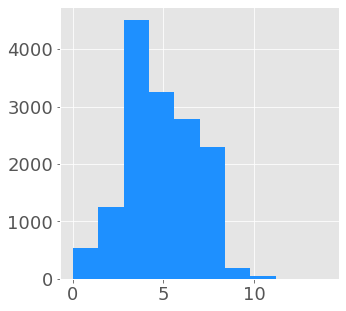

In [25]:
words_per_vid_s = pd.Series({k: len(v) for k, v in words.items()})
display(words_per_vid_s.describe())
words_per_vid_fig = words_per_vid_s.plot.hist(figsize=(5, 5), color="dodgerblue")
words_per_vid_fig.set_ylabel("")
save_fig(words_per_vid_fig, "words_per_vid_hist.png", figs_path)

Estadísticas sobre palabras por frecuencia

count    12779.000000
mean         2.225448
std          1.983290
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

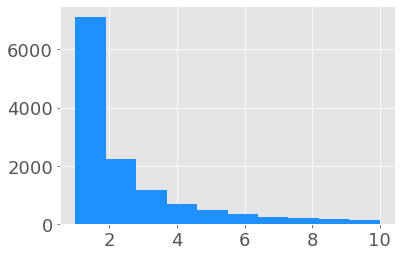

In [26]:
total_words = [word for label in words.values() for word in label]
word_count = Counter(total_words)

max_freq = 10
words_hist_range = {k:v for (k,v) in word_count.items() if v <= max_freq}
words_hist_range_s = pd.Series(words_hist_range).sort_values(ascending=False)

display(words_hist_range_s.describe())
words_hist_range_fig = words_hist_range_s.plot.hist(color=color)
words_hist_range_fig.set_ylabel("")
save_fig(words_hist_range_fig, f"words_hist_range_{max_freq}.png", figs_path)

Estadísticas acerca de palabras mas frecuentes:

count    14032.000000
mean         5.073974
std         16.254263
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        590.000000
dtype: float64

<AxesSubplot:>

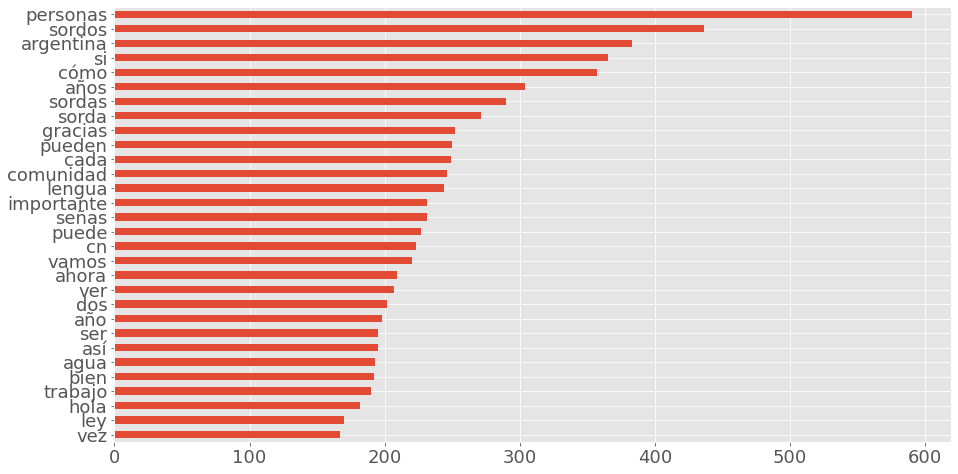

In [27]:
total_words_s = pd.Series(word_count).sort_values(ascending=False)
display(total_words_s.describe())
display(total_words_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

count    59720.000000
mean         1.192197
std          2.088675
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        251.000000
dtype: float64

<AxesSubplot:>

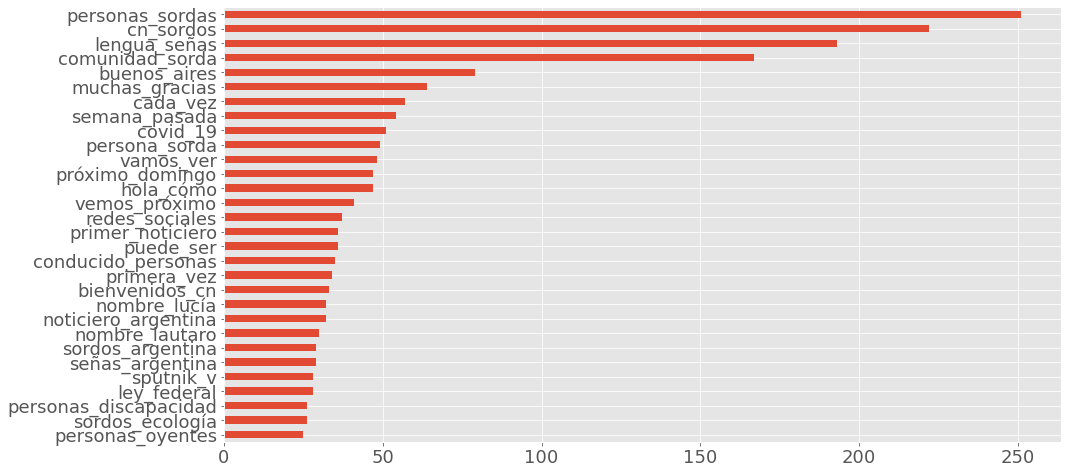

In [28]:
total_bigrams = ['_'.join(total_words[i:i + 2]) for i in range(len(total_words))]
bigram_count = Counter(total_bigrams)

total_bigrams_s = pd.Series(bigram_count).sort_values(ascending=False)
display(total_bigrams_s.describe())
display(total_bigrams_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

count    68125.000000
mean         1.045108
std          0.489458
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         35.000000
dtype: float64

<AxesSubplot:>

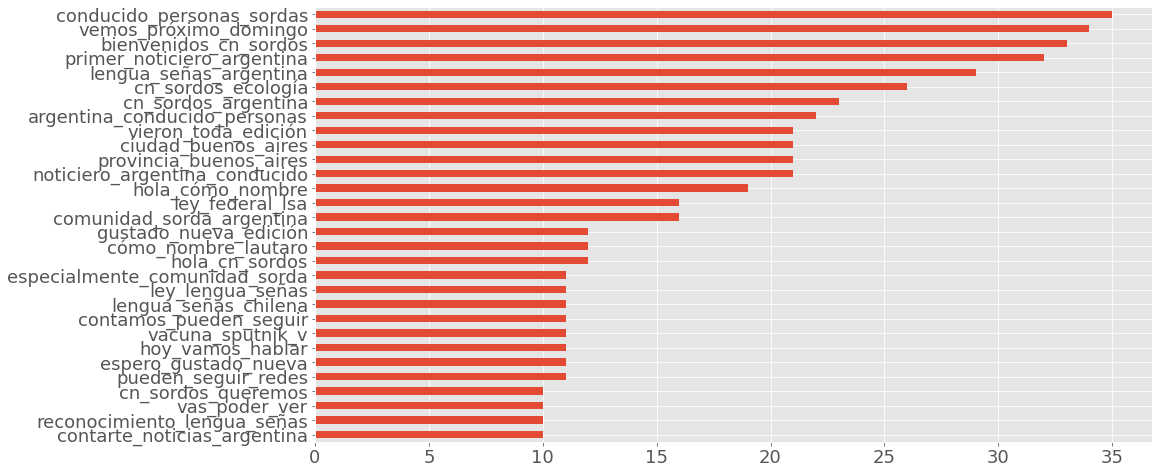

In [29]:
total_trigrams = ['_'.join(total_words[i:i + 3]) for i in range(len(total_words))]
trigram_count = Counter(total_trigrams)

total_trigrams_s = pd.Series(trigram_count).sort_values(ascending=False)
display(total_trigrams_s.describe())
display(total_trigrams_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))